In [ ]:
!pip install dowhy

In [26]:
import pandas as pd
from dowhy import CausalModel
import dowhy.datasets
import statsmodels.formula.api as smf

In [5]:
df = pd.read_csv('synthetic_crime_data.csv')

In [6]:
df.head()

,crime_rate,treated_location,post_law
0,81.168142,0,1
1,98.000000,1,0
2,59.290610,1,1
3,87.000000,1,0
4,56.794163,1,1


In [7]:
df.describe()

,crime_rate,treated_location,post_law
count,1000.000000,1000.00000,1000.00000
mean,87.800394,0.50000,0.50000
std,17.856388,0.50025,0.50025
min,41.191371,0.00000,0.00000
25%,72.396955,0.00000,0.00000
50%,91.088693,0.50000,0.50000
75%,101.000000,1.00000,1.00000
max,127.000000,1.00000,1.00000


In [8]:
df['treatment_group'] = df['treated_location'] * df['post_law']

In [9]:
pre_treatment_control_mean = df[(df['post_law'] == 0) & (df['treated_location'] == 0)]['crime_rate'].mean()
pre_treatment_treated_mean = df[(df['post_law'] == 0) & (df['treated_location'] == 1)]['crime_rate'].mean()
post_treatment_control_mean = df[(df['post_law'] == 1) & (df['treated_location'] == 0)]['crime_rate'].mean()
post_treatment_treated_mean = df[(df['post_law'] == 1) & (df['treated_location'] == 1)]['crime_rate'].mean()

diff_in_diff = (post_treatment_treated_mean - pre_treatment_treated_mean) - (post_treatment_control_mean - pre_treatment_control_mean)

print(f"Estimated treatment effect (DiD): {diff_in_diff}")

Estimated treatment effect (DiD): -27.22497029884908


In [10]:
model = CausalModel(
    data=df,
    treatment='treatment_group',
    outcome='crime_rate',
    common_causes=['treated_location', 'post_law']
)

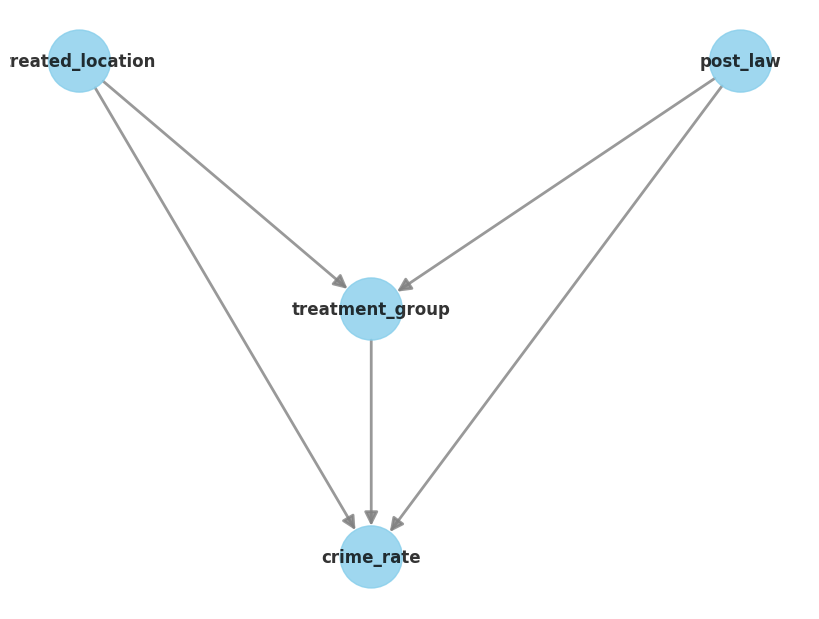

In [11]:
model.view_model(layout="dot")

In [31]:
identified_estimand = model.identify_effect()

causal_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print(causal_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                  
──────────────────(E[crime_rate|treated_location,post_law])
d[treatment_group]                                         
Estimand assumption 1, Unconfoundedness: If U→{treatment_group} and U→crime_rate then P(crime_rate|treatment_group,treated_location,post_law,U) = P(crime_rate|treatment_group,treated_location,post_law)

## Realized estimand
b: crime_rate~treatment_group+treated_location+post_law
Target units: ate

## Estimate
Mean value: -27.224970298849016



In [30]:
# Add random common cause
refutation_random = model.refute_estimate(identified_estimand, causal_estimate, method_name="random_common_cause")
print(refutation_random)

# Placebo treatment refutation
refutation_placebo = model.refute_estimate(identified_estimand, causal_estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(refutation_placebo)

# Data subset refutation
refutation_subset = model.refute_estimate(identified_estimand, causal_estimate, method_name="data_subset_refuter")
print(refutation_subset)

Refute: Add a random common cause
Estimated effect:-27.224970298849016
New effect:-27.225044726059306
p value:0.96

Refute: Use a Placebo Treatment
Estimated effect:-27.224970298849016
New effect:-0.010749149932280488
p value:0.94

Refute: Use a subset of data
Estimated effect:-27.224970298849016
New effect:-27.237721566022397
p value:0.98



# Following Book

In [14]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [15]:
df2 = pd.read_csv('synthetic_crime_data.csv')

In [16]:
df2.head()

,crime_rate,treated_location,post_law
0,81.168142,0,1
1,98.000000,1,0
2,59.290610,1,1
3,87.000000,1,0
4,56.794163,1,1


In [17]:
law_before = df2.query("treated_location==1 & post_law==0")["crime_rate"].mean()

law_after = df2.query("treated_location==1 & post_law==1")["crime_rate"].mean()

law_before - law_after

36.87969664778486

In [21]:
no_treat_before = df2.query("treated_location==0 & post_law==0")["crime_rate"].mean()

yes_treat_after = df2.query("treated_location==0 & post_law==1")["crime_rate"].mean()

no_treat_before - yes_treat_after

9.654726348935782

In [22]:
did = (law_after - law_before) - (yes_treat_after - no_treat_before)
did

-27.22497029884908

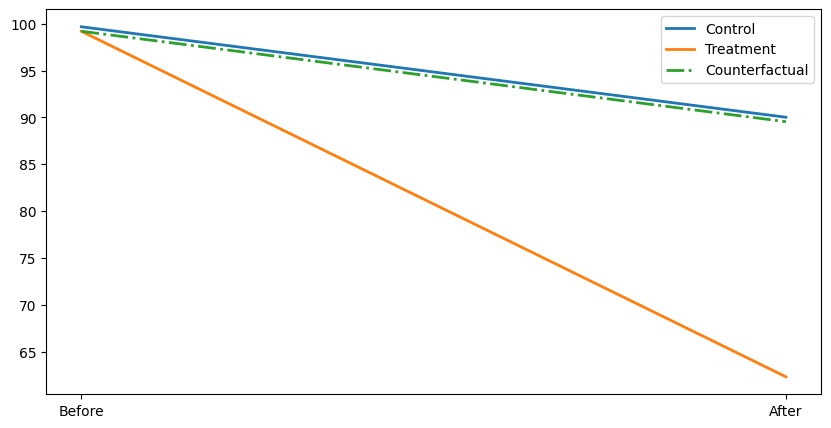

In [25]:
plt.figure(figsize=(10,5))
plt.plot(["Before", "After"], [no_treat_before, yes_treat_after], label="Control", lw=2)
plt.plot(["Before", "After"], [law_before, law_after], label="Treatment", lw=2)

plt.plot(["Before", "After"], [law_before, law_before + (yes_treat_after - no_treat_before)],
         label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend()
plt.show()

In [27]:
smf.ols('crime_rate ~ treated_location*post_law', data=df2).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,99.6720,0.592,168.385,0.000,98.510,100.834
treated_location,-0.4760,0.837,-0.569,0.570,-2.119,1.167
post_law,-9.6547,0.837,-11.533,0.000,-11.297,-8.012
treated_location:post_law,-27.2250,1.184,-22.997,0.000,-29.548,-24.902
